## Assignment 2 - Abdullah Naseem 19100085
**Note: the book uses summations which I have converted to vectorized implementation. This is because the dataset size is too large to use for loops** 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

### Loading Data

In [2]:
def load_files(directory):
    all_files = glob.glob(directory)
    all_reviews = {}
    for file in all_files:
        with open(file, 'r') as file_content:
            review = file_content.read()
            filename = file.split('/')[-1]
            all_reviews[filename] = review
    return all_reviews

In [3]:
train_pos_reviews = load_files('Dataset/train/pos/*')
train_neg_reviews = load_files('Dataset/train/neg/*')
test_pos_reviews = load_files('Dataset/test/pos/*')
test_neg_reviews = load_files('Dataset/test/neg/*')

print(len(train_pos_reviews))
print(len(train_neg_reviews))
print(len(test_pos_reviews))
print(len(test_pos_reviews))

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 803: character maps to <undefined>

### Preprocess Data

In [4]:
def preprocess(review_dict):
    with open('Dataset/positive-words.txt','r') as file_content:
        positive_lexicon = file_content.read().split('\n')
    with open('Dataset/negative-words.txt','r') as file_content:
        negative_lexicon = file_content.read().split('\n')
    
    preprocessed_reviews = []
    for filename, review in review_dict.items():
        review = review.lower()
#       Count of neg/pos words
#       Float64 minimizes errors 
        x_1 = np.float64(0)
        x_2 = np.float64(0)
        total = np.float64(0)
        for word in review.split():
            if word in positive_lexicon:
                x_1 += 1
            if word in negative_lexicon:
                x_2 += 1
            total += 1
#       Star rating
        i = filename.find('_')
        j = filename.find('.')
        x_3 = np.float64(filename[i+1:j])
        
#       log word count
        x_4 = np.log(total)
    
        if 'no' in review:
            x_5 = np.float64(1)
        else:
            x_5 = np.float64(0)
            
        if '!' in review:
            x_6 = np.float64(1)
        else:
            x_6 = np.float64(0)
        
        features = np.array([x_1, x_2, x_3, x_4, x_5, x_6])
        preprocessed_reviews.append(features)
        
    preprocessed_reviews = np.array(preprocessed_reviews)
    return preprocessed_reviews

In [5]:
train_pos_pre = preprocess(train_pos_reviews)
train_neg_pre = preprocess(train_neg_reviews)
test_pos_pre = preprocess(test_pos_reviews)
test_neg_pre = preprocess(test_neg_reviews)

In [6]:
print(train_pos_pre.shape)
print(train_neg_pre.shape)
print(test_pos_pre.shape)
print(test_neg_pre.shape)

(12500, 6)
(12500, 6)
(12500, 6)
(12500, 6)


In [7]:
train_pos_Y = np.array([1 for i in range(train_pos_pre.shape[0])]).reshape(-1,1)
train_neg_Y = np.array([0 for i in range(train_neg_pre.shape[0])]).reshape(-1,1)
test_pos_Y = np.array([1 for i in range(test_pos_pre.shape[0])]).reshape(-1,1)
test_neg_Y = np.array([0 for i in range(test_neg_pre.shape[0])]).reshape(-1,1)
print(train_pos_Y.shape)
print(train_neg_Y.shape)
print(test_pos_Y.shape)
print(test_neg_Y.shape)

(12500, 1)
(12500, 1)
(12500, 1)
(12500, 1)


In [8]:
train_X = np.concatenate((train_pos_pre, train_neg_pre))
print(train_X.shape)
train_Y = np.concatenate((train_pos_Y, train_neg_Y))
print(train_Y.shape)
test_X = np.concatenate((test_pos_pre, test_neg_pre))
print(test_X.shape)
test_Y = np.concatenate((test_pos_Y, test_neg_Y))
print(test_Y.shape)

(25000, 6)
(25000, 1)
(25000, 6)
(25000, 1)


### Helper Functions

In [9]:
# Was getting a "Divide by zero" error without this:
# Help from: https://stackoverflow.com/questions/38125319/python-divide-by-zero-encountered-in-log-logistic-regression
epsilon = np.float(1e-100)

In [10]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

In [11]:
def cross_entropy_loss(H, Y):
    return (-Y * np.log(H + epsilon) - (1 - Y) * np.log(1 - H + epsilon)).mean()

In [12]:
def hypothesis(X, thetas):
    Z = np.dot(X, thetas).reshape(-1,1)
    return sigmoid(Z)

In [13]:
def predict(X, thetas):
    H = hypothesis(X, thetas)
    predictions = []
    for h in H:
        if h[0] > 0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions = np.array(predictions).reshape(-1,1)
    return predictions

In [14]:
thetas = np.array([1 for i in range(train_X.shape[1])])
print(thetas)

[1 1 1 1 1 1]


In [15]:
hypotheses = hypothesis(train_X, thetas)
print(hypotheses)
print(hypotheses.shape)

[[1.        ]
 [1.        ]
 [1.        ]
 ...
 [1.        ]
 [0.99999943]
 [1.        ]]
(25000, 1)


In [16]:
predictions = predict(train_X, thetas)
print(predictions)
print(predictions.shape)

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
(25000, 1)


In [17]:
def derivative(X, H, Y):
    return np.dot(X.T, (H-Y)) / X.shape[0]

In [18]:
der = derivative(train_X, hypotheses, train_Y)
print(der)

[[3.29131539]
 [4.16639334]
 [1.1084696 ]
 [2.62032259]
 [0.45743787]
 [0.17659862]]


### Learning

In [19]:
def batch_gradient_descent(X, Y, n_epochs = 500, alpha = 0.01):
    thetas = np.array([np.float64(1) for i in range(X.shape[1])]).reshape(-1, 1)
    J = []
    for epoch in range(n_epochs):
        H = hypothesis(X, thetas)
        loss = cross_entropy_loss(H, Y)
        J.append(loss)
        
        der = derivative(X, H, Y)
        
        thetas -= alpha*der
    
    return J, thetas

In [20]:
def stochastic_gradient_descent(X, Y, n_epochs = 500, alpha = 0.01):
    thetas = np.array([np.float64(1) for i in range(X.shape[1])]).reshape(-1,1)
    J = []
    for epoch in range(n_epochs):
#       Go over each data point before updating the gradient
        for x, y in zip(X, Y):
            y = y.reshape(1,-1)
            x = x.reshape(1,-1)
            H = hypothesis(x, thetas)
            loss = cross_entropy_loss(H,y)
            J.append(loss)
            
            der = derivative(x,H,y)
            thetas -= alpha*der
            
    return J, thetas

In [21]:
J, thetas = batch_gradient_descent(train_X, train_Y)

In [22]:
J_stochastic, thetas_stochastic = stochastic_gradient_descent(train_X, train_Y)

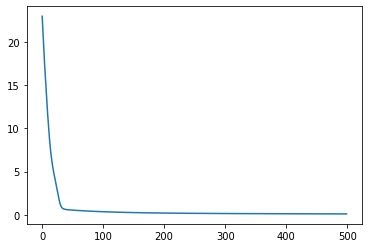

In [23]:
plt.plot(J)
plt.show()

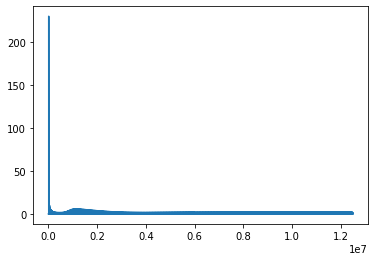

In [24]:
plt.plot(J_stochastic)
plt.show()

### Evaluation

In [25]:
test_preds = predict(test_X, thetas)
print(np.unique(test_preds))

[0 1]


In [26]:
test_preds_stochastic = predict(test_X, thetas_stochastic)

In [27]:
pos = 0
neg = 0
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
for true, pred in zip(test_Y, test_preds):
    if true == 1:
        pos += 1
        if pred == 1:
            true_pos += 1
        elif pred == 0:
            false_neg += 1
    elif true == 0:
        neg += 1
        if pred == 1:
            false_pos += 1
        elif pred == 0:
            true_neg += 1
            
accuracy = float(true_pos + true_neg) / float(true_pos + true_neg + false_pos + false_neg)
precision = float(true_pos) / float(true_pos + false_pos)
recall = float(true_pos) / float(true_pos + false_neg)
f1_score = (2*precision*recall) / (precision + recall)
print("Evaluation of Batch Gradient Descent")

print("Accuracy of the model is:", accuracy)
print("Precision of the model is:", precision)
print("Recall of the model is:", recall)
print("F1-Score of the model is:", f1_score)

confusion_matrix = np.array([
    [true_pos, false_pos],
    [false_neg, true_neg],
])
print("Confusion matrix:")
print(confusion_matrix)

Evaluation of Batch Gradient Descent
Accuracy of the model is: 0.99124
Precision of the model is: 0.9879996821107844
Recall of the model is: 0.99456
F1-Score of the model is: 0.9912689869632818
Confusion matrix:
[[12432   151]
 [   68 12349]]


In [28]:
pos = 0
neg = 0
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
for true, pred in zip(test_Y, test_preds_stochastic):
    if true == 1:
        pos += 1
        if pred == 1:
            true_pos += 1
        elif pred == 0:
            false_neg += 1
    elif true == 0:
        neg += 1
        if pred == 1:
            false_pos += 1
        elif pred == 0:
            true_neg += 1
            
accuracy = float(true_pos + true_neg) / float(true_pos + true_neg + false_pos + false_neg)
precision = float(true_pos) / float(true_pos + false_pos)
recall = float(true_pos) / float(true_pos + false_neg)
f1_score = (2*precision*recall) / (precision + recall)
print("Evaluation of Stochastic Gradient Descent")

print("Accuracy of the model is:", accuracy)
print("Precision of the model is:", precision)
print("Recall of the model is:", recall)
print("F1-Score of the model is:", f1_score)

confusion_matrix = np.array([
    [true_pos, false_pos],
    [false_neg, true_neg],
])
print("Confusion matrix:")
print(confusion_matrix)

Evaluation of Stochastic Gradient Descent
Accuracy of the model is: 0.99928
Precision of the model is: 1.0
Recall of the model is: 0.99856
F1-Score of the model is: 0.9992794812264831
Confusion matrix:
[[12482     0]
 [   18 12500]]
